# Likelihood-Based Link Prediction With Similarity Indexes
## Jaccard, Adamic-Adar, and Cosine Similarity

We implement and evaluate **likelihood-based link prediction** using three classic similarity scores:

1. **Jaccard similarity**
2. **Adamic---Adar similarity**
3. **Cosine similarity**

We will:
- estimate class-conditional likelihood densities from histograms,
- build the **Bayes-optimal classifier** (minimum misclassification error under the model) based on the **likelihood ratio test**,
- explain why the Bayes-optimal threshold may be undesirable in sparse networks,
- introduce **precision**, **recall**, and the **F1-score**,
- compute **precision---recall curves** and choose the threshold that maximizes F1,
- summarize results in a table.

Throughout, we work with an **undirected** Facebook friendship network loaded from GitHub.

## 1. Load the Facebook graph

The dataset is stored as an **edge list**: each line contains two integers representing a friendship edge.
We download the file from GitHub if needed, then load it as an undirected `networkx.Graph`.

In [10]:
import networkx as nx
import urllib.request
from pathlib import Path

DATA_URL = "https://raw.githubusercontent.com/vmpreciado/DS4CN/main/FacebookSmall.txt"
LOCAL_FILE = Path("FacebookSmall.txt")

def looks_like_html(path: Path, nbytes: int = 200) -> bool:
    """Heuristic check: some downloads accidentally save HTML instead of raw data."""
    try:
        head = path.read_text(encoding="utf-8", errors="ignore")[:nbytes].lower()
    except Exception:
        return False
    return "<!doctype" in head or "<html" in head

need_download = (not LOCAL_FILE.exists()) or looks_like_html(LOCAL_FILE)

if need_download:
    if LOCAL_FILE.exists():
        print("Local file exists but looks invalid. Re-downloading raw dataset...")
    else:
        print("Downloading Facebook edge list from GitHub...")
    urllib.request.urlretrieve(DATA_URL, LOCAL_FILE)
    print(f"Download completed: {LOCAL_FILE.resolve()}")
else:
    print(f"Using local file: {LOCAL_FILE.resolve()}")

FB = nx.read_edgelist(LOCAL_FILE, create_using=nx.Graph(), nodetype=int)

n = FB.number_of_nodes()
m = FB.number_of_edges()
print("Facebook graph loaded.")
print(f"  nodes n: {n:,}")
print(f"  edges m: {m:,}")
print(f"  average degree 2m/n: {2*m/n:.3f}")
print(f"  directed?: {FB.is_directed()}")

Using local file: /Users/victormpreciado/Library/Application Support/JetBrains/DataSpell2025.1/projects/workspace/FacebookSmall.txt
Facebook graph loaded.
  nodes n: 4,039
  edges m: 88,234
  average degree 2m/n: 43.691
  directed?: False


## 2. Similarity scores

We compute three similarity scores for a node pair $(i,j)$:

- **Jaccard**:
  $\text{Jacc}(i,j)=\frac{|N(i)\cap N(j)|}{|N(i)\cup N(j)|}$

- **Adamic-Adar**:
  $\text{AA}(i,j)=\sum_{r\in N(i)\cap N(j)} \frac{1}{\log(d_r)}$

- **Cosine similarity (undirected, unweighted)**:
  $\text{CS}(i,j)=\frac{|N(i)\cap N(j)|}{\sqrt{d_i d_j}}$

(Cosine similarity is called “cosine” because it equals the cosine of the angle between adjacency vectors.)

In [11]:
import math
import numpy as np
import random

# Reproducibility
SEED = 7
random.seed(SEED)
np.random.seed(SEED)

degrees = dict(FB.degree())
nodes = list(FB.nodes())
neighbors = {u: set(FB.neighbors(u)) for u in nodes}

def jaccard(i, j):
    Ni = neighbors[i]
    Nj = neighbors[j]
    union = Ni | Nj
    if not union:
        return 0.0
    return len(Ni & Nj) / len(union)

def adamic_adar(i, j):
    common = neighbors[i] & neighbors[j]
    score = 0.0
    for r in common:
        dr = degrees.get(r, 0)
        # avoid log(0) or log(1)
        if dr <= 1:
            continue
        score += 1.0 / math.log(dr)
    return score

def cosine_similarity(i, j):
    di = degrees[i]
    dj = degrees[j]
    if di == 0 or dj == 0:
        return 0.0
    common = neighbors[i] & neighbors[j]
    return len(common) / math.sqrt(di * dj)

## 3. Build a labeled dataset of node pairs

We need labeled examples:
- **positive** pairs: connected by an edge
- **negative** pairs: disconnected (non-edges)

To keep the notebook fast and simple, we sample a balanced dataset (same number of positives and negatives).
Later, we discuss why real networks are highly imbalanced.

In [12]:
N_POS = 10_000
N_NEG = 10_000
MAX_TRIES = 2_000_000

edges = list(FB.edges())
edge_set = set((min(u,v), max(u,v)) for (u,v) in edges)

# positives: sample edges with replacement
pos_pairs = [random.choice(edges) for _ in range(N_POS)]

# negatives: rejection sample non-edges
neg_pairs = []
tries = 0
while len(neg_pairs) < N_NEG and tries < MAX_TRIES:
    u, v = random.sample(nodes, 2)
    key = (min(u,v), max(u,v))
    if key not in edge_set:
        neg_pairs.append((u,v))
    tries += 1

if len(neg_pairs) < N_NEG:
    raise RuntimeError(f"Only sampled {len(neg_pairs)} negatives after {MAX_TRIES} tries.")

print("Sampled pairs:")
print(f"  positives (edges):    {len(pos_pairs):,}")
print(f"  negatives (nonedges): {len(neg_pairs):,}")

Sampled pairs:
  positives (edges):    10,000
  negatives (nonedges): 10,000


## 4. Computing Similarity Features and Train/Test Split

In this step, we transform each sampled node pair into a **feature vector**
based on structural similarity measures.

For every node pair $(i,j)$, we compute:
- the **Jaccard similarity**,
- the **Adamic-Adar similarity**, and
- the **cosine similarity**.

Each pair is also assigned a **label**:
- $y=1$ if the pair is **Connected** (there is an edge between $i$ and $j$),
- $y=0$ if the pair is **Disconnected** (there is no edge).

### Why do we split into training and testing sets?

To evaluate link prediction methods fairly, we must separate:
- **training data** ($\approx 70\%$ of data points), used to estimate model quantities, and
- **testing data** ($\approx 30\%$ of data points), used only for evaluation.

In this notebook:
- The **training set** is used to estimate the **class-conditional likelihoods**
  $\Pr(Similarity \mid \text{Connected})$ and $\Pr(Similarity \mid \text{Disconnected})$
  via histograms.
- The **testing set** is used to evaluate decision rules, compute error rates,
  and assess precision-recall tradeoffs.

This separation ensures that our performance estimates reflect
**generalization to unseen node pairs**, rather than memorization of the data.

> **Important:**
> The split is performed *after* computing similarity scores, but before any
> likelihood estimation or threshold selection. This prevents information
> leakage from the test set into the classifier design.

In [4]:
import pandas as pd

def compute_features(pairs, label):
    rows = []
    for (i,j) in pairs:
        rows.append({
            "i": i,
            "j": j,
            "y": label,  # 1 = connected, 0 = disconnected
            "jacc": jaccard(i,j),
            "aa": adamic_adar(i,j),
            "cs": cosine_similarity(i,j),
        })
    return rows

df = pd.DataFrame(compute_features(pos_pairs, 1) + compute_features(neg_pairs, 0))

# Shuffle and split
df = df.sample(frac=1.0, random_state=SEED).reset_index(drop=True)
split = int(0.7 * len(df))
train = df.iloc[:split].copy()
test  = df.iloc[split:].copy()

print("Train label counts:")
print(train["y"].value_counts())
print("Test label counts:")
print(test["y"].value_counts())

Train label counts:
y
1    7004
0    6996
Name: count, dtype: int64
Test label counts:
y
0    3004
1    2996
Name: count, dtype: int64


## 5. Likelihood Estimation Using Histograms

To implement a likelihood-ratio test, we need estimates of the
**class-conditional likelihood functions**:
- $\Pr(Similarity \mid \text{Connected})$
- $\Pr(Similarity \mid \text{Disconnected})$

Here, $Similarity$ denotes a similarity score (e.g., Jaccard, Adamic---Adar, or cosine).

### Why likelihoods?

The likelihood $\Pr(Similarity \mid \text{Connected})$ measures how likely it is to
observe a similarity value $Similarity$ **assuming that the node pair is connected**.
Similarly, $\Pr(Similarity \mid \text{Disconnected})$ measures how likely the same
score would be if the pair were not connected.

These likelihood functions are the key ingredients in the
**likelihood-ratio test**, which compares how plausible an observed score is
under the two competing hypotheses.

### Histogram-based estimation

Because we do not know the true underlying likelihoods analytically, we
estimate them empirically using the **training set**:

1. We collect all similarity scores $Similarity$ corresponding to
   connected pairs in the training data and build a histogram to approximate
   $\Pr(Similarity \mid \text{Connected})$.
2. We repeat the same procedure for disconnected pairs to approximate
   $\Pr(Similarity \mid \text{Disconnected})$.

Both histograms are constructed using the **same bin edges**, so that the
resulting density estimates are directly comparable at every score value.

### Smoothing (Avoiding Zero Likelihoods)

When estimating likelihoods using histograms, it is possible for some bins to
contain no samples from the training data. In such cases, the estimated
likelihood in that bin would be exactly zero.

This is problematic for likelihood-ratio tests, because a zero likelihood in
either class would lead to division by zero or infinite likelihood ratios.

To prevent this, we apply **additive smoothing** as follows:

- After computing the histogram counts (or densities) for each class,
  we add a small constant $\varepsilon > 0$ to every bin.
- The smoothed likelihood estimates then satisfy
  $$
    \Pr(\text{Similarity} \mid \text{Connected}) > 0,
    \qquad
    \Pr(\text{Similarity} \mid \text{Disconnected}) > 0
  $$
  for all similarity values.

In practice, $\varepsilon$ is chosen to be very small (e.g., $10^{-12}$), so that
it does not noticeably distort the estimated distributions but ensures numerical
stability when computing likelihood ratios.

> **Remark:**
> Histogram-based likelihood estimation is simple and transparent. More advanced density estimation
> techniques (e.g., kernel density estimation) can be used in practice, but the
> histogram approach already captures the essential ideas behind
> likelihood-based link prediction.

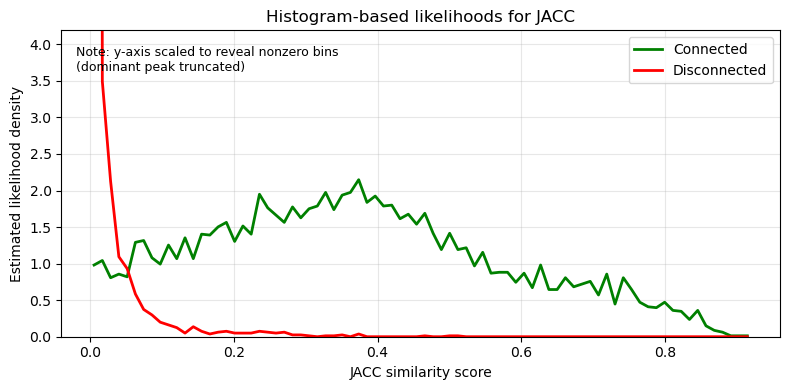

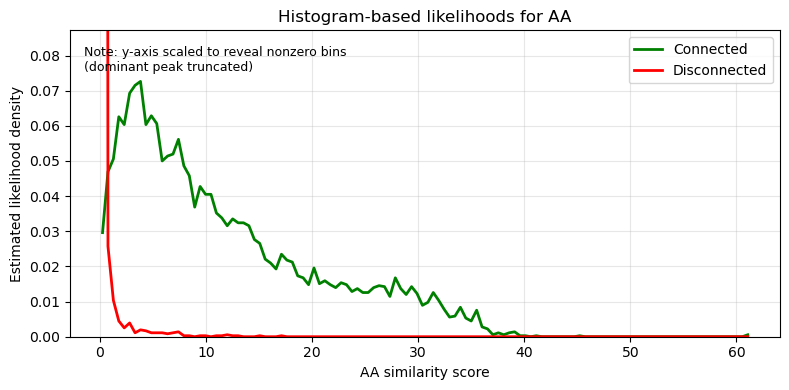

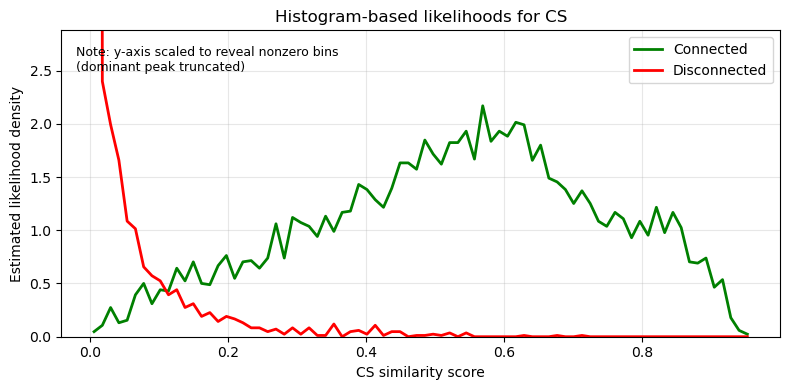

In [15]:
import numpy as np
import matplotlib.pyplot as plt


def fit_hist_density(scores_pos, scores_neg, bins=80, eps=1e-12):
    """
    Fit histogram-based density estimators for positive (connected)
    and negative (disconnected) scores using a common binning.
    """
    scores_all = np.concatenate([scores_pos, scores_neg])
    lo, hi = scores_all.min(), scores_all.max()
    if lo == hi:
        hi = lo + 1e-9

    # Histogram-based density estimates
    hist_pos, bin_edges = np.histogram(
        scores_pos, bins=bins, range=(lo, hi), density=True
    )
    hist_neg, _ = np.histogram(
        scores_neg, bins=bins, range=(lo, hi), density=True
    )

    # Additive smoothing to avoid zero likelihoods
    hist_pos = hist_pos + eps
    hist_neg = hist_neg + eps

    return bin_edges, hist_pos, hist_neg


def hist_density_eval(score, bin_edges, hist_density):
    """
    Evaluate a histogram-based density at a given score
    by locating the corresponding bin.
    """
    idx = np.searchsorted(bin_edges, score, side="right") - 1
    idx = int(np.clip(idx, 0, len(hist_density) - 1))
    return float(hist_density[idx])


# ------------------------------------------------------------
# Fit likelihood models and visualize histograms
# ------------------------------------------------------------
models = {}

for feature, bins in [("jacc", 80), ("aa", 120), ("cs", 80)]:
    pos = train.loc[train["y"] == 1, feature].to_numpy()
    neg = train.loc[train["y"] == 0, feature].to_numpy()

    bin_edges, hist_pos, hist_neg = fit_hist_density(pos, neg, bins=bins)
    models[feature] = (bin_edges, hist_pos, hist_neg)

    # --------------------------------------------------------
    # Plot the estimated likelihood functions (with y-axis truncation)
    # --------------------------------------------------------
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

    # Identify dominant peak (typically near zero)
    combined = np.maximum(hist_pos, hist_neg)
    max_idx = np.argmax(combined)

    # Exclude the dominant bin to find the largest "non-peak" value
    other_vals = np.delete(combined, max_idx)
    max_other = other_vals.max() if len(other_vals) > 0 else combined[max_idx]

    # Truncate only if the peak is much larger than the rest
    spike_ratio = 5.0
    headroom = 1.20

    if combined[max_idx] / max_other >= spike_ratio:
        ymax = max_other * headroom
        truncate = True
    else:
        ymax = combined.max() * headroom
        truncate = False

    plt.figure(figsize=(8, 4))
    plt.plot(bin_centers, hist_pos, color="green", lw=2, label="Connected")
    plt.plot(bin_centers, hist_neg, color="red", lw=2, label="Disconnected")

    plt.xlabel(f"{feature.upper()} similarity score")
    plt.ylabel("Estimated likelihood density")
    plt.title(f"Histogram-based likelihoods for {feature.upper()}")
    plt.ylim(0, ymax)
    plt.grid(True, alpha=0.3)
    plt.legend(loc="upper right")

    if truncate:
        plt.text(
            0.02, 0.95,
            "Note: y-axis scaled to reveal nonzero bins\n(dominant peak truncated)",
            transform=plt.gca().transAxes,
            fontsize=9,
            va="top"
        )

    plt.tight_layout()
    plt.show()

## 6. Bayes-Optimal Classifier (Minimum Misclassification Error)

We now implement the **Bayes-optimal decision rule**, which minimizes the
**overall probability of misclassification** under the assumed probabilistic
model.

### Bayes decision rule

Given an observed similarity score $s$, Bayes' rule compares the two
posterior probabilities:
$$
\Pr(\text{Connected} \mid s)
\qquad \text{and} \qquad
\Pr(\text{Disconnected} \mid s).
$$

Using Bayes' theorem, this comparison is equivalent to comparing:
$$
\Pr(s \mid \text{Connected})\,\Pr(\text{Connected})
\quad \text{and} \quad
\Pr(s \mid \text{Disconnected})\,\Pr(\text{Disconnected}).
$$

We predict **Connected** if the first quantity is larger, and
**Disconnected** otherwise.

### Graph-level prior probabilities

In an undirected graph with $n$ nodes and $m$ edges, the prior probability
that a randomly selected pair of nodes is connected can be approximated by:
$$
\Pr(\text{Connected})
\;\approx\;
\frac{m}{\binom{n}{2}}\;=\; 1.08\%.
$$

Similarly, the probability that a random node pair is disconnected is:
$$
\Pr(\text{Disconnected})
\;\approx\;
1 - \Pr(\text{Connected})\;=\;98.92\%.
$$

These priors reflect the **sparsity of real networks**, where the number of
edges $m$ is typically much smaller than the total number of possible node
pairs $\binom{n}{2}$.

### Implementation and Evaluation

We now implement the **Bayes-optimal classifier** based on the
likelihood-ratio test:
$$
\frac{
	\Pr(s \mid \text{Connected})
}{
	\Pr(s \mid \text{Disconnected})
}
\;\underset{\text{Disconnected}}{\overset{\text{Connected}}{\gtrless}}\;
\frac{
	\Pr(\text{Disconnected})
}{
	\Pr(\text{Connected})
}
\;\approx\;
\frac{
	\binom{n}{2}-m
}{
	m
}
\;=\;
91.4.
$$

This means that, *a priori*, a randomly chosen pair of nodes is more than
90 times more likely to be **Disconnected** than **Connected**.

We then apply this decision rule to the **test set** and evaluate its
performance by computing the **total error rate**, i.e., the fraction of
node pairs that are misclassified.

In [16]:
# Graph-level priors (not the sampled dataset priors)
p_conn = m / (n*(n-1)/2)
p_disc = 1.0 - p_conn

print("Graph-level priors:")
print(f"  P(Connected)    ~= {p_conn:.6e}")
print(f"  P(Disconnected) ~= {p_disc:.6e}")
print(f"  Prior ratio P(Disconn)/P(Conn) ~= {p_disc/p_conn:.3e}")

def bayes_predict(score, model, p_conn, p_disc):
    """Predict Connected if p(s|Conn)P(Conn) > p(s|Disconn)P(Disconn)."""
    bin_edges, p_s_conn, p_s_disc = model
    ls_conn = hist_density_eval(score, bin_edges, p_s_conn)
    ls_disc = hist_density_eval(score, bin_edges, p_s_disc)
    return 1 if (ls_conn * p_conn) > (ls_disc * p_disc) else 0

def total_error_rate(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=int)
    y_pred = np.asarray(y_pred, dtype=int)
    return float(np.mean(y_true != y_pred))

bayes_results = []
for feature in ["jacc","aa","cs"]:
    y_true = test["y"].to_numpy()
    scores = test[feature].to_numpy()
    y_pred = np.array([bayes_predict(s, models[feature], p_conn, p_disc) for s in scores], dtype=int)
    err = total_error_rate(y_true, y_pred)
    bayes_results.append((feature, err, int(y_pred.sum())))
    print(f"{feature.upper():4s}: total error rate = {err:.4f} | predicted connected = {int(y_pred.sum()):,} out of {len(y_pred):,}")

Graph-level priors:
  P(Connected)    ~= 1.081996e-02
  P(Disconnected) ~= 9.891800e-01
  Prior ratio P(Disconn)/P(Conn) ~= 9.142e+01
JACC: total error rate = 0.2205 | predicted connected = 1,695 out of 6,000
AA  : total error rate = 0.2438 | predicted connected = 1,549 out of 6,000
CS  : total error rate = 0.1878 | predicted connected = 1,897 out of 6,000


### Bayes-optimal classifier performance

Using the Bayes-optimal decision rule (which minimizes **overall
misclassification probability**), we obtain the following results on the test set:

- **Jaccard similarity**: Total error rate: **22.05\%**

- **Adamic---Adar similarity**: Total error rate: **24.38\%**

- **Cosine similarity**: Total error rate: **18.78\%**

> **Conclusion**:
> **Cosine similarity should be used if the objective is to minimize the total error rate**.

### What does the total error rate mean?

The **total error rate** is the fraction of node pairs in the test set that are
classified incorrectly:
$$
\text{Total error rate}
=
\frac{\text{Number of misclassified pairs}}
{\text{Total number of test pairs}}.
$$

This includes **two types of mistakes**:
- predicting *Connected* when the pair is actually disconnected (false positives), and
- predicting *Disconnected* when the pair is actually connected (false negatives).

The Bayes-optimal classifier is designed to **minimize this single quantity**,
treating all errors equally.


### Interpretation

- Because the network is extremely sparse, the Bayes-optimal rule is heavily
  influenced by the large prior probability of disconnection.
- As a result, the classifier favors predicting *Disconnected*, leading to
  relatively low total error rates but also to many missed true links.
- This behavior is appropriate if minimizing overall error is the goal, but it
  may be undesirable in applications where recovering true connections is more
  important.

This motivates moving beyond total error rate and introducing alternative
evaluation criteria that explicitly balance different types of errors.

## 7. An Alternative Objective: Beyond Bayes-Optimality

The Bayes-optimal classifier is designed to minimize the **total
misclassification error**, treating all errors equally.

However, in **very sparse networks**, the prior probability
$$
\Pr(\text{Connected}) \ll \Pr(\text{Disconnected})
$$
is extremely small. As a result, the Bayes-optimal rule tends to be
**highly conservative**, predicting *Disconnected* for most node pairs.

In many link prediction applications, the goal is not simply to minimize
total error, but rather to:
- identify **plausible candidate links**, and
- control the tradeoff between predicting too many false links and missing
  true ones.

To support this goal, we adopt a **threshold-based approach** of the form:
$$
\frac{
	\Pr(s \mid \text{Connected})
}{
	\Pr(s \mid \text{Disconnected})
}
\;\underset{\text{Disconnected}}{\overset{\text{Connected}}{\gtrless}}\;
\tau
$$
in which the decision threshold $\tau$ is treated as a **tunable parameter**.

The performance of the resulting binary classifier depends on the choice of
$\tau$ and is evaluated using metrics that explicitly distinguish between
different types of errors.

These metrics are **Precision**, **Recall**, and the
**F1 score**, described in the next cell.

## 8. Precision, Recall, and the F1 Score

When we use a threshold-based decision rule, each pair of nodes is classified
as either **Connected** or **Disconnected**. Comparing these predictions with
the true network structure produces different types of outcomes.

### Types of classification outcomes

For a given threshold $\tau$, we define:

- **TP (True Positives):** pairs that are truly connected and correctly
  predicted as *Connected*.
- **FP (False Positives):** pairs that are actually disconnected but are
  incorrectly predicted as *Connected*.
- **FN (False Negatives):** pairs that are actually connected but are
  incorrectly predicted as *Disconnected*.

These quantities capture *how* the classifier makes mistakes, not just
*how many* mistakes it makes.

### Precision

**Precision** measures the fraction of links predicted by the classifier that
actually exist in the network:
$$
\text{Precision}
=
\frac{\text{TP}}{\text{TP}+\text{FP}},
$$
where $\text{TP}+\text{FP}$ is the total number of links that the algorithm
claims exist.

**Interpretation:**
Among all node pairs that the algorithm predicts as *Connected*, precision is
the fraction that are truly connected.

- High precision means **few false links** are predicted.
- Low precision means many predicted links do not actually exist.

Precision is important when false positives are costly or undesirable.

### Recall

**Recall** measures the fraction of true links that the classifier manages to recover:
$$
\text{Recall}
=
\frac{\text{TP}}{\text{TP}+\text{FN}},
$$
where $\text{TP}+\text{FN}$ is the total number of true links in the evaluation subset.

**Interpretation:**
Among all node pairs that are truly connected, recall is the fraction that the
algorithm successfully identifies.

- High recall means **most true links are found**.
- Low recall means many real connections are missed.

Recall is important when missing true links is costly.

### Precision–Recall Tradeoff

In practice, **precision and recall are often in tension**, meaning that
improving one typically comes at the expense of the other.

- Using a **smaller decision threshold** $\tau$ increases the number of
  predicted links.
  - This typically **increases recall**, because more true links are recovered.
  - However, it also **decreases precision**, since many additional predicted
    links may be false.

- Using a **larger decision threshold** $\tau$ decreases the number of
  predicted links.
  - This typically **increases precision**, because only the most confident
    links are predicted.
  - However, it **reduces recall**, since many true links are missed.

This tradeoff is entirely controlled by the **decision threshold** $\tau$ in the
likelihood-ratio test. By varying $\tau$, we move along different operating
points that favor either:
- recovering as many true links as possible (high recall), or
- ensuring that predicted links are highly reliable (high precision).

There is no single universally optimal choice of $\tau$. Instead, $\tau$ must be selected based on the desired tradeoff between precision and recall. A common heuristic is to choose the threshold that maximizes the **F1 score**, which balances both objectives. This approach is introduced and implemented below.

### F1 Score

The **F1 score** provides a single summary measure that balances both precision
and recall:
$$
F_1
=
\frac{2\cdot\text{Precision}\,\text{Recall}}
{\text{Precision}+\text{Recall}}.
$$

The F1 score is high only when **both precision and recall are high**.
It penalizes classifiers that perform well on one metric but poorly on the other.

**Why F1 is useful here:**
In link prediction, we want to recover meaningful connections without predicting
too many spurious ones. The F1 score captures this balance in a single number,
making it a convenient criterion for selecting the decision threshold.

## 9. Precision–Recall Curves

We now evaluate the performance of each similarity measure by sweeping the
decision threshold $\tau$ in the likelihood-ratio test and computing the
corresponding **precision–recall curve**.

Specifically, for each value of $\tau$, we:
- classify node pairs using the likelihood ratio,
$$
\frac{
	\Pr(Similarity \mid \text{Connected})
}{
	\Pr(Similarity \mid \text{Disconnected})
}
\;\underset{\text{Disconnected}}{\overset{\text{Connected}}{\gtrless}}\;
\tau
$$
- compute the resulting precision and recall for each value of $\tau$,
- record how these quantities change as $\tau$ varies.

This process produces a precision–recall curve for each value of the $Similarity$ measure.
Finally, we select the threshold $\tau^\star$ that **maximizes the F1 score**,
providing a principled balance between precision and recall.

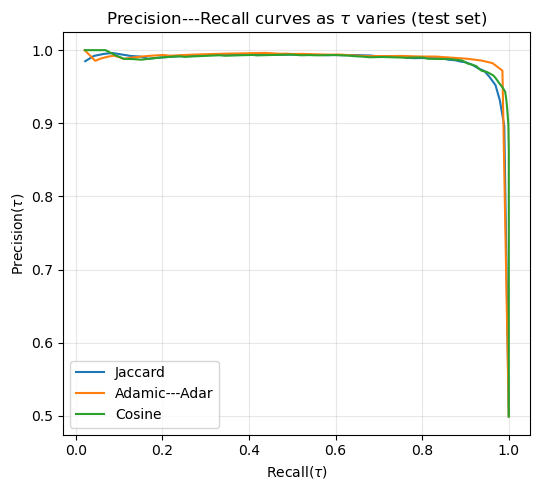

In [33]:
import matplotlib.pyplot as plt

def precision_recall_f1(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=int)
    y_pred = np.asarray(y_pred, dtype=int)

    tp = int(np.sum((y_true==1) & (y_pred==1)))
    fp = int(np.sum((y_true==0) & (y_pred==1)))
    fn = int(np.sum((y_true==1) & (y_pred==0)))

    precision = tp / (tp + fp) if (tp + fp) > 0 else 1.0
    recall    = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1        = (2*precision*recall)/(precision+recall) if (precision+recall)>0 else 0.0
    return precision, recall, f1

def sweep_thresholds_on_lr(feature, model, p_conn, p_disc, test_df, num_thresholds=250):
    """Sweep thresholds on posterior odds LR(s) and compute precision/recall/F1."""
    y_true = test_df["y"].to_numpy()
    scores = test_df[feature].to_numpy()

    bin_edges, p_s_conn, p_s_disc = model

    lr_vals = np.array([
        (hist_density_eval(s, bin_edges, p_s_conn) * p_conn) /
        (hist_density_eval(s, bin_edges, p_s_disc) * p_disc)
        for s in scores
    ], dtype=float)

    taus = np.quantile(lr_vals, np.linspace(0, 1, num_thresholds))

    precision_list, recall_list, f1_list = [], [], []
    for tau in taus:
        y_pred = (lr_vals >= tau).astype(int)
        p, r, f1 = precision_recall_f1(y_true, y_pred)
        precision_list.append(p); recall_list.append(r); f1_list.append(f1)

    return taus, np.array(precision_list), np.array(recall_list), np.array(f1_list), lr_vals

pr_results = {}
for feature in ["jacc","aa","cs"]:
    taus, prec, rec, f1, lr_vals = sweep_thresholds_on_lr(
        feature, models[feature], p_conn, p_disc, test, num_thresholds=250
    )
    pr_results[feature] = dict(taus=taus, precision=prec, recall=rec, f1=f1)

plt.figure(figsize=(5.5,5))
for feature, label in [("jacc","Jaccard"), ("aa","Adamic---Adar"), ("cs","Cosine")]:
    plt.plot(pr_results[feature]["recall"], pr_results[feature]["precision"], label=label)
plt.xlabel(r"Recall($\tau$)")
plt.ylabel(r"Precision($\tau$)")
plt.title(r"Precision---Recall curves as $\tau$ varies (test set)")
plt.grid(True, alpha=0.3)
plt.legend(loc="lower left")
plt.tight_layout()
plt.show()

## 10. Choosing a Decision Threshold: Bayes-Optimal vs. F1-Optimal

For each similarity measure, we now compare two threshold choices:

1. **Bayes-optimal threshold** (minimum misclassification error under the model).
   In terms of posterior odds, this corresponds to the rule:
   $$
    \text{LR}(s)
    \;\underset{\text{Disconnected}}{\overset{\text{Connected}}{\gtrless}}\;
    \frac{\Pr(\text{Disconnected})}{\Pr(\text{Connected})}.
    $$
   so the Bayes threshold is $\tau_{\text{Bayes}} = \frac{\Pr(\text{Disconnected})}{\Pr(\text{Connected})} = 91.4$.

2. **F1-optimal threshold** (best balance of precision and recall).
   We sweep $\tau$ over a grid and choose:
   $$
   \tau^\star = \arg\max_\tau F_1(\tau).
   $$

These two thresholds typically lead to different operating points because:
- the Bayes rule optimizes total error,
- the F1 rule balances precision and recall.

Below, we compute and compare both thresholds for each similarity measure, and we
visualize the corresponding operating points on the precision---recall curve.

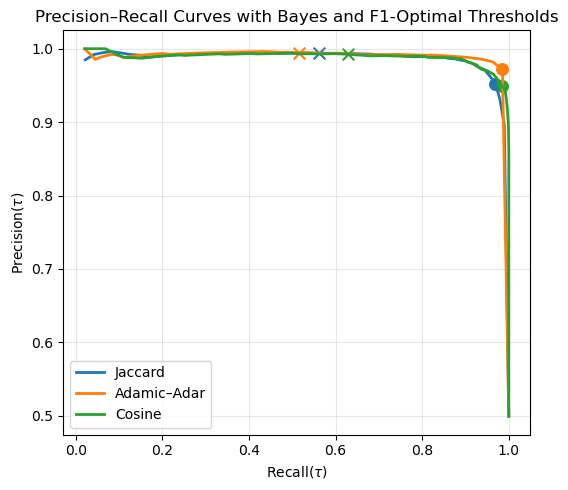

,Similarity,tau_Bayes,Precision@tau_Bayes,Recall@tau_Bayes,F1@tau_Bayes,tau_star (max F1),Precision@tau_star,Recall@tau_star,F1@tau_star
0,Jaccard,1.0,0.993510,0.562083,0.717971,0.008567,0.952131,0.969292,0.960635
1,Adamic–Adar,1.0,0.994835,0.514352,0.678108,0.019952,0.972012,0.985314,0.978618
2,Cosine,1.0,0.992620,0.628505,0.769671,0.006123,0.949485,0.984980,0.966907


In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# ------------------------------------------------------------
# Helper: compute posterior-odds LR_post(s) on the test set
# ------------------------------------------------------------
def compute_lr_post(feature, model, p_conn, p_disc, test_df):
    """
    LR_post(s) = p(s|Conn) P(Conn) / (p(s|Disconn) P(Disconn))
    """
    scores = test_df[feature].to_numpy()
    bin_edges, p_s_conn, p_s_disc = model

    return np.array([
        (hist_density_eval(s, bin_edges, p_s_conn) * p_conn) /
        (hist_density_eval(s, bin_edges, p_s_disc) * p_disc)
        for s in scores
    ], dtype=float)


# ------------------------------------------------------------
# Compare Bayes-optimal vs F1-optimal thresholds
# and plot all PR curves in ONE figure
# ------------------------------------------------------------
y_true = test["y"].to_numpy()
tau_bayes = 1.0  # Bayes-optimal threshold for posterior odds

summary_rows = []

plt.figure(figsize=(5.5, 5))

for feature, name, color in [
    ("jacc", "Jaccard", "tab:blue"),
    ("aa", "Adamic–Adar", "tab:orange"),
    ("cs", "Cosine", "tab:green"),
]:
    # Precision–Recall curve (already computed by sweeping tau)
    taus = pr_results[feature]["taus"]
    prec = pr_results[feature]["precision"]
    rec = pr_results[feature]["recall"]
    f1 = pr_results[feature]["f1"]

    # Plot PR curve
    plt.plot(rec, prec, color=color, lw=2, label=name)

    # F1-optimal threshold
    idx_star = int(np.argmax(f1))
    tau_star = float(taus[idx_star])
    p_star = float(prec[idx_star])
    r_star = float(rec[idx_star])
    f1_star = float(f1[idx_star])

    # Bayes-optimal operating point (tau = 1 on posterior odds)
    lr_post = compute_lr_post(feature, models[feature], p_conn, p_disc, test)
    y_pred_bayes = (lr_post >= tau_bayes).astype(int)
    p_bayes, r_bayes, f1_bayes = precision_recall_f1(y_true, y_pred_bayes)

    # Mark the two operating points
    plt.scatter(r_star, p_star, color=color, s=70, marker="o")
    plt.scatter(r_bayes, p_bayes, color=color, s=70, marker="x")

    # Store results
    summary_rows.append({
        "Similarity": name,
        "tau_Bayes": tau_bayes,
        "Precision@tau_Bayes": p_bayes,
        "Recall@tau_Bayes": r_bayes,
        "F1@tau_Bayes": f1_bayes,
        "tau_star (max F1)": tau_star,
        "Precision@tau_star": p_star,
        "Recall@tau_star": r_star,
        "F1@tau_star": f1_star
    })

# Finalize plot
plt.xlabel(r"Recall($\tau$)")
plt.ylabel(r"Precision($\tau$)")
plt.title("Precision–Recall Curves with Bayes and F1-Optimal Thresholds")
plt.grid(True, alpha=0.3)
plt.legend(loc="lower left")
plt.tight_layout()
plt.show()

# Comparison table
results_table = pd.DataFrame(summary_rows)
results_table

## Interpretation: Bayes-Optimal vs. F1-Optimal Performance

The table above highlights an important and instructive contrast between
different similarity measures and different optimization objectives.

- **Cosine similarity** achieves the **lowest total error rate** under the
  Bayes-optimal classifier. This means that, when the goal is to minimize the
  overall number of misclassified pairs (treating all errors equally), cosine
  similarity performs best.

- However, when we shift our objective to balancing **precision and recall**,
  a different picture emerges.
  The **Adamic–Adar similarity** achieves the **highest F1 score**, indicating
  a better tradeoff between:
  - predicting links that are reliable (high precision), and
  - recovering a large fraction of true links (high recall).

This illustrates a key lesson in link prediction:

> The “best” similarity measure depends on the **performance criterion** being
> optimized.

Minimizing total error favors conservative classifiers in sparse networks,
while maximizing the F1 score favors classifiers that recover more true links,
even at the cost of some additional false positives.

As a result, **cosine similarity** is best under a Bayes-optimal error criterion,
whereas **Adamic–Adar similarity** is often preferable when the goal is to
identify meaningful candidate links with a balanced precision–recall tradeoff.

## Final Takeaway

- Local similarity measures such as **Jaccard**, **Adamic–Adar**, and **cosine**
  can be turned into effective **link prediction methods** by estimating
  class-conditional likelihoods and applying a threshold-based decision rule.
- The **Bayes-optimal classifier** minimizes the average probability of error,
  but in **sparse networks** it is often overly conservative and predicts very
  few links.
- By introducing **precision**, **recall**, and the **F1 score**, we obtain a
  practical framework for selecting decision thresholds that balance different
  types of errors and better reflect the goals of link prediction tasks.